# Heart Descent Methods

This notebook is meant to only reproduce a portion of the coordinate descent methodology. It isn't a full classification / regression attempt, but rather an attempt at scratch-implementing a hypothetical model's training process with coordinate descent. The end result is to mimic the behavior of coordinate descent, namely the process of repeatedly updating features weights while seeking to minimize the overall model loss function. 

### High-Level Overview of Steps

My loss function implemented will be based off the formula for binary cross-entropy, shown below. Note that the end value is averaged across all data points used, i.e. rows in X array.

$$L = \frac{1}{N}\sum_{i=1}^{N} {y}*{log(\hat{y})}+{(1-y)}*{log(1-\hat{y})}$$

Baseline loss will be calculated once, and stored, using a sklearn.linear_model.LogisticRegresion method piped through a parameter grid search (sklearn.model_selection.GridSearchCV). The next block of pseudo-code will loop until the scratch-build implementation's loss is within tolerance of the baseline loss.

        1. Calculate label probabilities for the iteration
        2. Store iteration loss value
        3. Solve for iteration dL/dw values for all features
        4. Choose a coordinate index to update based on parameter, by either...
            a. randomly select coordinate
                OR 
            b. adaptively choose coordinate based on descending dL/dw value
        5. Adjust weight according to coordinate descent formula

$$w_{t+1} = w_{t} - \eta*\frac{\partial{L}}{\partial{w}}$$

Ultimately, the loss function will need to be both differentiable and convex: differentiable to ensure loss function is locally linear, and convex to ensure that a global maximum exists and can be found reliably. A function that satifies these two conditions is usable for coordinate descent, though this isn't strictly necessary.

### Coordinate Descent Implementation

In [1]:
# module imports
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
# data import and normalization
data = np.loadtxt('heart.csv', delimiter = ',', skiprows = 1)
data, labels = np.hsplit(data, (data.shape[1] - 1,))
data = MinMaxScaler().fit_transform(data)
data = np.hstack([np.ones((data.shape[0], 1)), data])

In [3]:
# class for coordinate descent
class CoordinateDescent:
    '''
    Scratch-built implementation of coordinate descent.

        Parameters:
            selector_method (str) : coordinate selection method, defaults to 'a'
                'a' : adaptive, by descending gradient value 
                'r' : random, keeps you on your toes
            step_size (float) : step size for weight adjustment, defaults to .001
            tolerance (float) : tolerance used when minimizing loss function, defaults to .001

        Returns:
            none
    '''

    def __init__(self, selector_method = 'a', step_size = .001, tolerance = .001):
        self.selector_method = selector_method
        self.step_size = step_size
        self.tolerance = tolerance
    
    def sigmoidify(self, val):
        '''
        Returns sigmoidified (between 1 and 0) value.

            Parameters:
                val (float) : float
            
            Returns:
                sig_val (float) : sigmoided (between 1 and 0) float
        '''

        return 1.0/(1.0 + np.exp(-val))

    def baseline(self, X, y):
        '''
        Finds and stores log loss baseline value for grid searched logistic regression classifier.

            Parameters:
                X (array) : data
                y (array) : labels
            
            Returns:
                none
        '''
        # logistic regression base model
        model = LogisticRegression(max_iter = 1200)
        
        # params to grid search through
        ones = np.mean(labels == 1)
        weights = {1: ones, 0: 1.0 - ones}
        cs = np.linspace(0, 5).tolist()[1:] + np.linspace(5, 10, 10).tolist()[1:]
        params = [\
            {'C': cs, 'class_weight': [weights, 'balanced', None],'penalty': ['l2'], \
                'solver': ['lbfgs', 'newton-cg', 'sag']},
            {'C': cs, 'class_weight': [weights, 'balanced', None], 'penalty': ['l1', 'l2'], \
                'solver': ['liblinear', 'saga']}]
        
        # the actual parameter search
        grid = GridSearchCV(model, params, n_jobs = -1)
        grid.fit(X, y.flatten())

        # calculating and storing final loss
        y_proba = grid.predict_proba(X)
        self.grid = grid
        self.loss_baseline = log_loss(y, y_proba)
        
    def spelunk(self, X, y):
        '''
        Uses the designated coordinate descent method to route itself down to the loss function's global minimum.

            Parameters:
                X (array) : data
                y (array) : labels
            
            Returns:
                none
        '''

        # weights and loss storage
        weights = np.zeros((X.shape[1], 1))
        self.log_losses = []

        # counters
        cycle = 0
        self.iteration = 0

        # find baseline
        self.baseline(X, y)

        # loop for weight updates
        while True:
            # storing log loss value
            y_proba = self.sigmoidify(np.dot(weights.T, X.T))
            loss = log_loss(y, y_proba.T) # -np.sum(y*np.log(y_proba) - (1.0 - y)*np.log(1.0 - y_proba))/X.shape[0]
            self.log_losses.append(loss)

            # calculating dL/dw
            dels = np.dot((y_proba - y.T), X)
            
            # updating chosen coordinate weight
            if self.selector_method == 'r':
                rng = np.random.default_rng()
                num = rng.integers(0, 14)
            elif self.selector_method == 'c':
                num = cycle
                end = X.shape[1] - 1
                cycle += 1 if cycle < end else -end
            else:
                num = np.argmax(np.abs(dels))
            weights[num, 0] -= self.step_size*dels[0, num]
            
            # end of iteration housekeeping
            self.iteration += 1
            self.weights = weights
            if np.abs(self.loss_baseline - loss) <= self.tolerance:
                break

In [4]:
# running coordinate descent with each selector method
t1 = time.time()
cd_a = CoordinateDescent()
cd_a.spelunk(data, labels)
t2 = time.time()
cd_r = CoordinateDescent(selector_method = 'r')
cd_r.spelunk(data, labels)
t3 = time.time()
cd_c = CoordinateDescent(selector_method = 'c')
cd_c.spelunk(data, labels)
t4 = time.time()
iter1, iter2, iter3 = len(cd_a.log_losses), len(cd_r.log_losses), len(cd_c.log_losses)
del_iter_12, del_iter_13, del_iter_23 = iter1 - iter2, iter1 - iter3, iter3 - iter2
time1, time2, time3 = t2 - t1, t3 - t2, t4 - t3
del_time_12, del_time_13, del_time_23 = time1 - time2, time1 - time3, time3 - time2

In [5]:
# performance comparison between selectors
print(f"'a' selector:\n\titerations (count): {iter1}\n\ttime (seconds): {round(time1, 4)}\n")
print(f"'c' selector:\n\titerations (count): {iter3}\n\ttime (seconds): {round(time3, 4)}\n")
print(f"'r' selector:\n\titerations (count): {iter2}\n\ttime (seconds): {round(time2, 4)}\n")
print(f"'a' improvement over 'c':\n\tdelta iterations (cnt, %): ({del_iter_13}, {round(100*del_iter_13/iter3, 4)}%)\n")
print(f"\tdelta time (s, %): ({del_time_13}, {round(100*del_time_13/time3, 4)}%)")
print(f"'a' improvement over 'r':\n\tdelta iterations (cnt, %): ({del_iter_12}, {round(100*del_iter_12/iter2, 4)}%)\n")
print(f"\tdelta time (s, %): ({del_time_12}, {round(100*del_time_12/time2, 4)}%)\n")
print(f"'c' improvement over 'r':\n\tdelta iterations (cnt, %): ({del_iter_23}, {round(100*del_iter_23/iter2, 4)}%)\n")
print(f"\tdelta time (s, %): ({del_time_23}, {round(100*del_time_23/time2, 4)}%)\n")

'a' selector:
	iterations (count): 4327
	time (seconds): 5.8369

'c' selector:
	iterations (count): 6698
	time (seconds): 6.0441

'r' selector:
	iterations (count): 6786
	time (seconds): 6.4272

'a' improvement over 'c':
	delta iterations (cnt, %): (-2371, -35.3986%)

	delta time (s, %): (-0.20722746849060059, -3.4286%)
'a' improvement over 'r':
	delta iterations (cnt, %): (-2459, -36.2364%)

	delta time (s, %): (-0.5903449058532715, -9.1851%)

'c' improvement over 'r':
	delta iterations (cnt, %): (-88, -1.2968%)

	delta time (s, %): (-0.3831174373626709, -5.9609%)



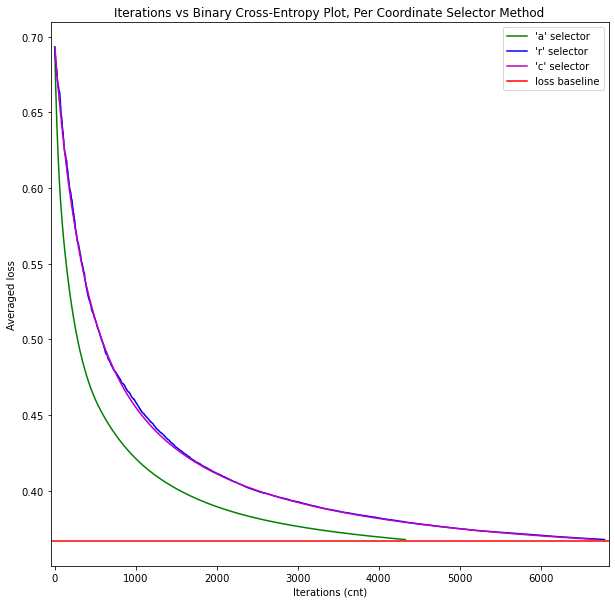

In [6]:
# comparing plotted loss vs iteration functions for selector methods
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.plot(range(1, cd_a.iteration + 1), cd_a.log_losses, 'g', label = "'a' selector")
ax.plot(range(1, cd_r.iteration + 1), cd_r.log_losses, 'b', label = "'r' selector")
ax.plot(range(1, cd_c.iteration + 1), cd_c.log_losses, 'm', label = "'c' selector")
ax.plot(ax.get_xlim(), [cd_a.loss_baseline]*2, 'r-', label = 'loss baseline')
ax.legend(loc = 'upper right')
ax.set_xlabel('Iterations (cnt)')
ax.set_ylabel('Averaged loss')
ax.set_xlim(-50, iter2 + 50)
ax.set_title('Iterations vs Binary Cross-Entropy Plot, Per Coordinate Selector Method')
plt.show()

Unsurprisingly, the 'a' adaptive coordinate method came out on top, with a 35% improvement on iterations to convergence. Between the 'r' and 'c' selector methods, 'c' saw slight improvements on iteration count and time though not by significant margins. Perhaps the most notable difference between the latter two underperforming coordinate selector methods, other than iteration and completion time, was the more smoothed nature of the iterations vs average loss plot.